In [1]:
# The notebook shows how to annotate SMART-seq2 reads from bam file and estimate RNA velocity and the challenges I faced
# The explanation and other details can be found here - http://pklab.med.harvard.edu/velocyto/notebooks/R/chromaffin2.nb.html

In [2]:
if (!require(BiocManager)) {
  install.packages("BiocManager")
}
BiocManager::install()

Loading required package: BiocManager

Bioconductor version '3.12' is out-of-date; the current release version '3.14'
  is available with R version '4.1'; see https://bioconductor.org/install

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.16), R 4.0.5 (2021-03-31)



In [3]:
BiocManager::valid()

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org




[1] TRUE

In [4]:
#BiocManager::install(c("GenomicFeatures", "AnnotationDbi"))
#BiocManager::install("pcaMethods")
#install.packages("hdf5r")
#install.packages("Rcpp")
#install.packages("igraph")
#problems with these packages was solved on installing r-velocyto.r via Bioconda

In [5]:
#if (!require(devtools)) {
#  install.packages("devtools")

#} ## error
# try this command on ubuntu - sudo apt-get install libgit2-dev ## no luck 
#install.packages('devtools', repos='http://cran.rstudio.com/') ## error
# devtools was giving error - installed devtools via the cran repo, problem with this is also installs a whole lot of unneccsary files
#sudo apt-get update 
#sudo apt-get upgrade ## not working as well

# sudo apt install r-cran-devtools 

In [6]:
#conda install -c r r-devtools ** worked **

In [11]:
#install.packages("devtools")
library("devtools")

In [12]:
# First created an r-environment in Conda called r-velocity and installed all the required dependencies there
# conda -n create r-velocity 
# conda activate r-velocity

# I also installed jupyter notebook with R as someone in stack overflow mentioned the issue could be with R studio
# conda install r-recommended r-irkernel
# conda install Jupyter
# R -e 'IRkernel::installspec()'
# jupyter-notebook ## will get you started...

In [13]:
# # After the difficulty with devtools, I ran into several issues to install velocyto.R as well 

# git clone https://github.com/velocyto-team/velocyto.R
# conda install -c conda-forge boost
# conda install -c conda-forge openmp
# R CMD build velocyto.R
# R CMD INSTALL velocyto.R_0.6.tar.gz #ERROR: dependencies ‘Rcpp’, ‘pcaMethods’, ‘igraph’, ‘hdf5r’, ‘RcppArmadillo’ are not available for package ‘velocyto.R’

# All these other ways to install velocyto on R studio was also giving error
# setwd("~/R")
# devtools::install_local("velocyto.R")
# devtools::install_github("velocyto-team/velocyto.R")
# remotes::install_github("velocyto-team/velocyto.R")

# This is what worked for me !!
# conda install r-velocyto.r # Bioconda worked - yaay!! This installs all the dependencies as well
# conda update r-velocyto.r #

In [14]:
library("velocyto.R")

Loading required package: Matrix



In [15]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/savita/miniconda3/envs/r-env/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] velocyto.R_0.6      Matrix_1.3-4        devtools_2.4.2     
[4] usethis_2.1.3       BiocManager_1.30.16

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7          pillar_1.6.4        compiler_4.0.5     
 [4] prettyunits_1.1.1   base64enc_0.1-3     remotes_2.4.1      
 [7] tools_4.0.5         testthat_3.1.0      digest_0.6.28      
[10] pkgbuild_1.

In [16]:
#Read in cell cluster assignment and tSNE embedding used in the Furlan et al. (Science’17).
ldat <- readRDS(url("http://pklab.med.harvard.edu/velocyto/chromaffin/ldat.rds"))
str(ldat)

List of 4
 $ spliced  :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:2724270] 3 9 10 13 14 17 19 20 28 29 ...
  .. ..@ p       : int [1:385] 0 7100 14272 21376 28491 36017 43375 50956 57637 64998 ...
  .. ..@ Dim     : int [1:2] 23420 384
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:23420] "Xkr4" "Rp1" "Sox17" "Mrpl15" ...
  .. .. ..$ : chr [1:384] "onefilepercell_A1_unique_and_others_J2CH1:A1_unique.bam" "onefilepercell_A1_unique_and_others_J2CH1:A10_unique.bam" "onefilepercell_A1_unique_and_others_J2CH1:A11_unique.bam" "onefilepercell_A1_unique_and_others_J2CH1:A12_unique.bam" ...
  .. ..@ x       : num [1:2724270] 24 3 22 136 48 21 15 32 109 13 ...
  .. ..@ factors : list()
 $ unspliced:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:1528882] 0 4 10 13 14 17 19 20 23 29 ...
  .. ..@ p       : int [1:385] 0 3911 8043 12057 16176 20795 25046 29389 33438 37382 ...
  .. ..@ Dim     : int [1:2] 23420 384
  .. ..@

In [17]:
ldat <- lapply(ldat,function(x) {
  colnames(x) <-  gsub("_unique.bam","",gsub(".*:","",colnames(x)))
  x
})

In [18]:
cell.colors <- readRDS(url("http://pklab.med.harvard.edu/velocyto/chromaffin/cell.colors.rds"))
emb <- readRDS(url("http://pklab.med.harvard.edu/velocyto/chromaffin/embedding.rds"))

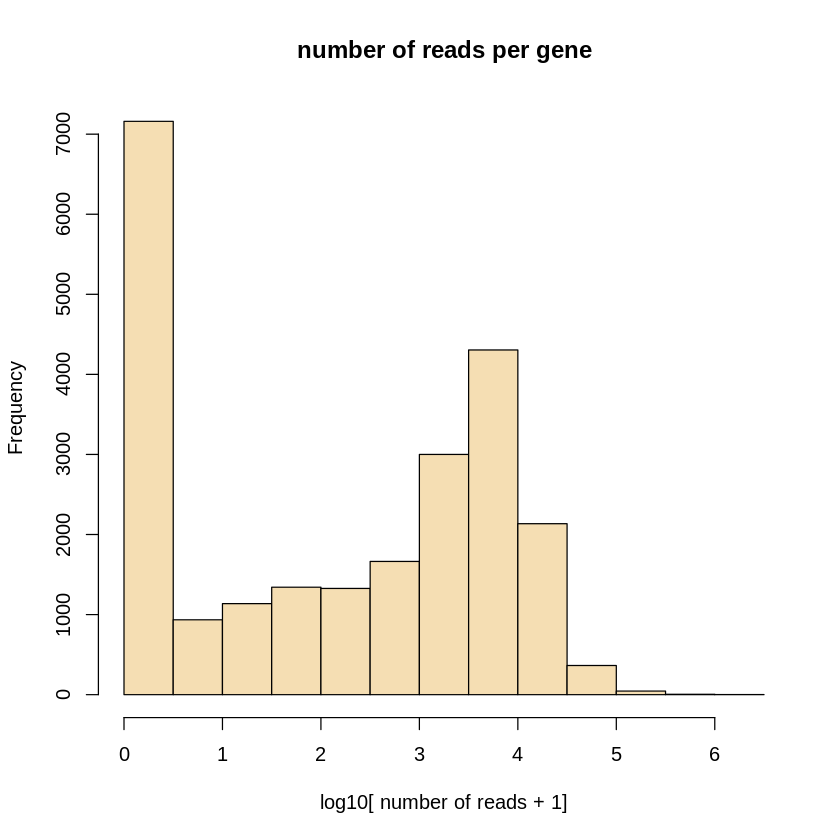

In [19]:
#Gene filtering
#Spliced expression magnitude distribution across genes:

hist(log10(rowSums(ldat$spliced)+1),col='wheat',xlab='log10[ number of reads + 1]',main='number of reads per gene')

In [20]:
#Set up expression matrices, filtering genes to leave those that exceed some pre-defined g to the average expression magnitude

# exonic read (spliced) expression matrix
emat <- ldat$spliced;
# intronic read (unspliced) expression matrix
nmat <- ldat$unspliced
# spanning read (intron+exon) expression matrix
smat <- ldat$spanning;
# filter expression matrices based on some minimum max-cluster averages
emat <- filter.genes.by.cluster.expression(emat,cell.colors,min.max.cluster.average = 5)
nmat <- filter.genes.by.cluster.expression(nmat,cell.colors,min.max.cluster.average = 1)
smat <- filter.genes.by.cluster.expression(smat,cell.colors,min.max.cluster.average = 0.5)
# look at the resulting gene set
length(intersect(rownames(emat),rownames(nmat)))

[1] 8548

In [21]:
# and if we use spanning reads (smat)
length(intersect(intersect(rownames(emat),rownames(nmat)),rownames(smat)))

[1] 1696

In [22]:
#Several variants of velocity estimates using gene-relative model
#Using min/max quantile fit, in which case gene-specific offsets do not require spanning read (smat) fit
fit.quantile <- 0.05;
rvel.qf <- gene.relative.velocity.estimates(emat,nmat,deltaT=1,kCells = 5,fit.quantile = fit.quantile)

calculating cell knn ... done
calculating convolved matrices ... done
fitting gamma coefficients ... done. succesfful fit for 8548 genes
filtered out 1306 out of 8548 genes due to low nmat-emat correlation
filtered out 754 out of 7242 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


log ... pca ... pc multipliers ... delta norm ... done
done


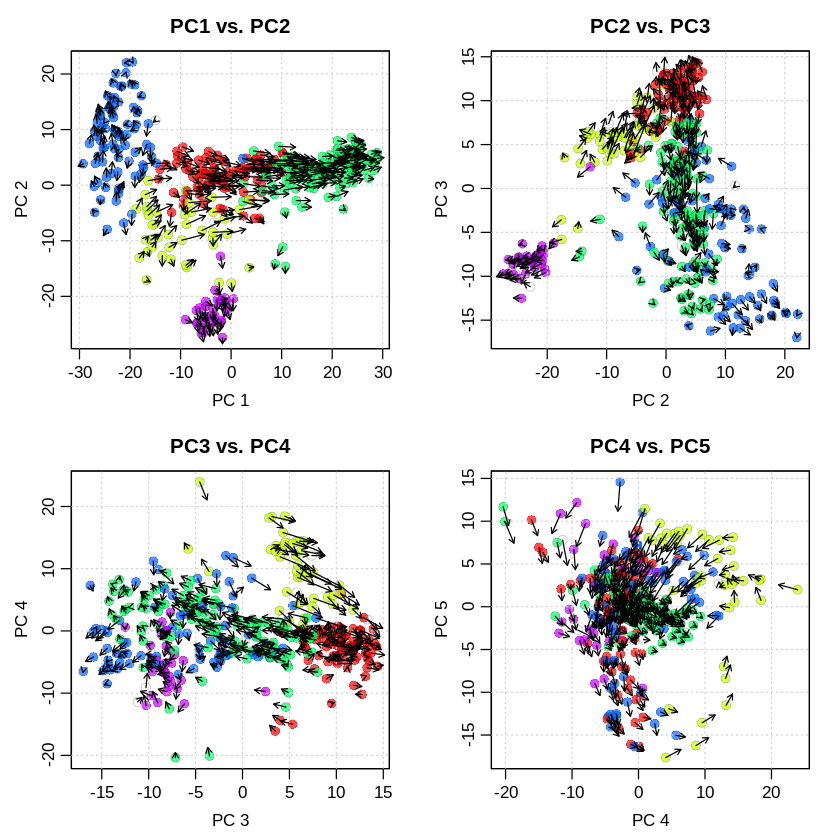

In [23]:
#We visualize the velocities by projecting observed and extrapolated cells onto the first 5 PCs
pca.velocity.plot(rvel.qf,nPcs=5,plot.cols=2,cell.colors=ac(cell.colors,alpha=0.7),cex=1.2,pcount=0.1,pc.multipliers=c(1,-1,-1,-1,-1))

calculating convolved matrices ... done


[1] 1

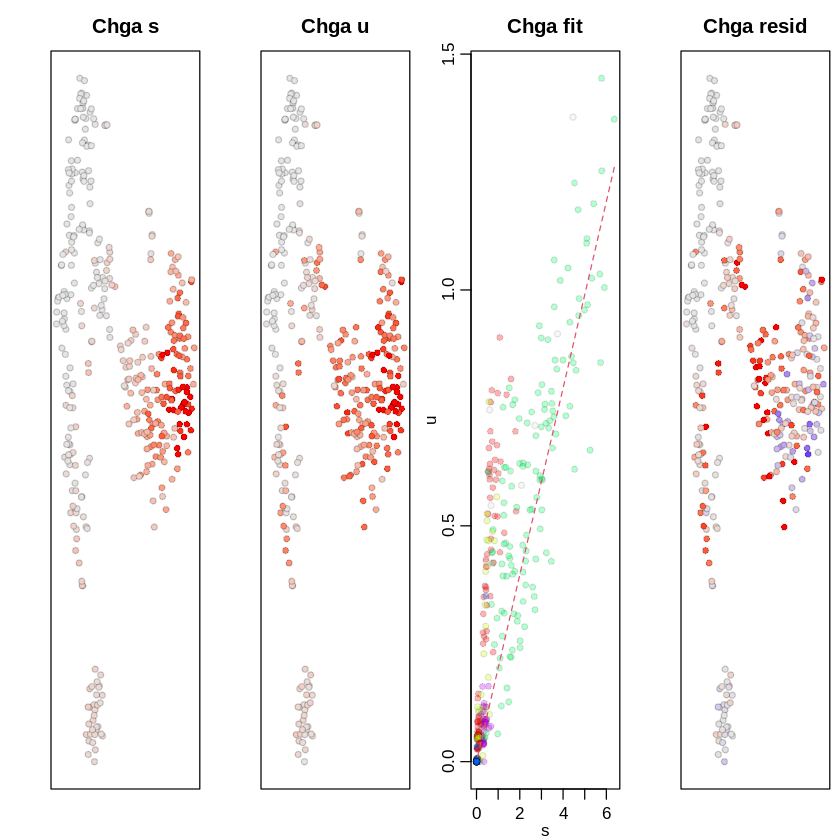

In [24]:
#Fitting of individual genes can be visualized using “show.gene” option. To save time, we’ll pass previously-calculated velocity (rvel.qf) to save calculation time:
# define custom pallet for expression magnitude
gene.relative.velocity.estimates(emat,nmat, kCells = 5,fit.quantile = fit.quantile,old.fit=rvel.qf,show.gene='Chga',cell.emb=emb,cell.colors=cell.colors)

In [25]:
#Alternatively, we calculate gene-relative velocity, using k=5 cell kNN pooling, but now using 
#entire range of expression to determine slope gamma, and using spanning reads (smat) to fit the gene offsets.
rvel <- gene.relative.velocity.estimates(emat,nmat,smat=smat, kCells = 5, fit.quantile=fit.quantile, diagonal.quantiles = TRUE)

calculating cell knn ... done
calculating convolved matrices ... done
fitting smat-based offsets ... done
fitting gamma coefficients ... done. succesfful fit for 1696 genes
filtered out 26 out of 1696 genes due to low nmat-smat correlation
filtered out 138 out of 1670 genes due to low nmat-emat correlation
filtered out 14 out of 1532 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


log ... pca ... pc multipliers ... delta norm ... done
done


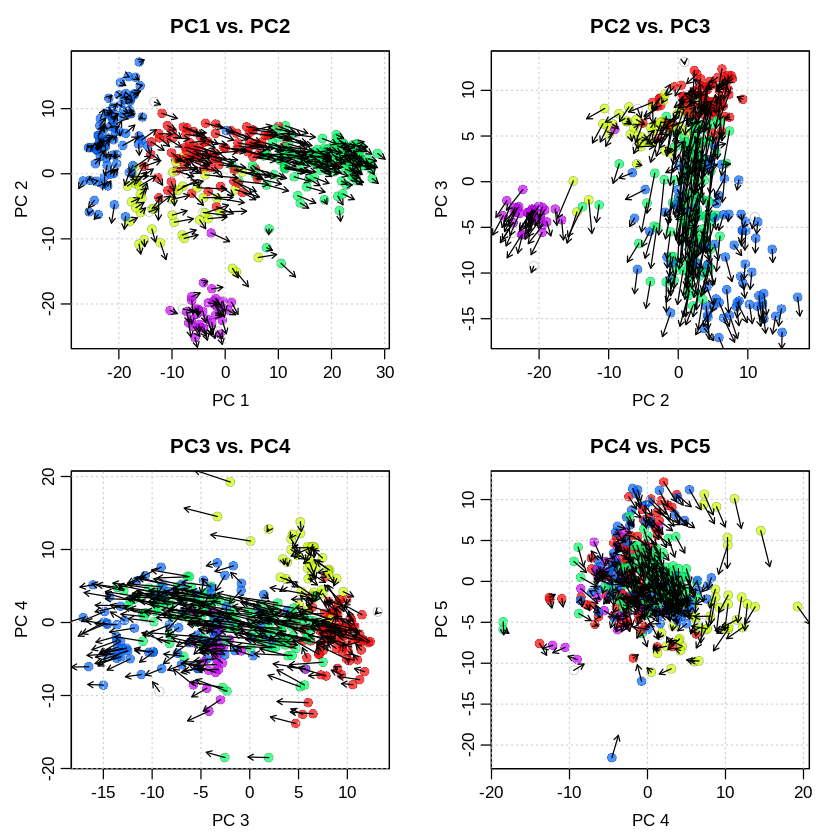

In [26]:
#We can visualize the velocity in PCA space:
pca.velocity.plot(rvel,nPcs=5,plot.cols=2,cell.colors=ac(cell.colors,alpha=0.7),cex=1.2,pcount=0.1,pc.multipliers=c(1,-1,1,1,1))

In [27]:
#we calculate the most basic version of velocity estimates, using relative gamma fit, without cell kNN smoothing:
rvel1 <- gene.relative.velocity.estimates(emat,nmat,deltaT=1,deltaT2 = 1,kCells = 1, fit.quantile=fit.quantile)

fitting gamma coefficients ... done. succesfful fit for 8548 genes
filtered out 783 out of 8548 genes due to low nmat-emat correlation
filtered out 1330 out of 7765 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


log ... pca ... pc multipliers ... delta norm ... done
done


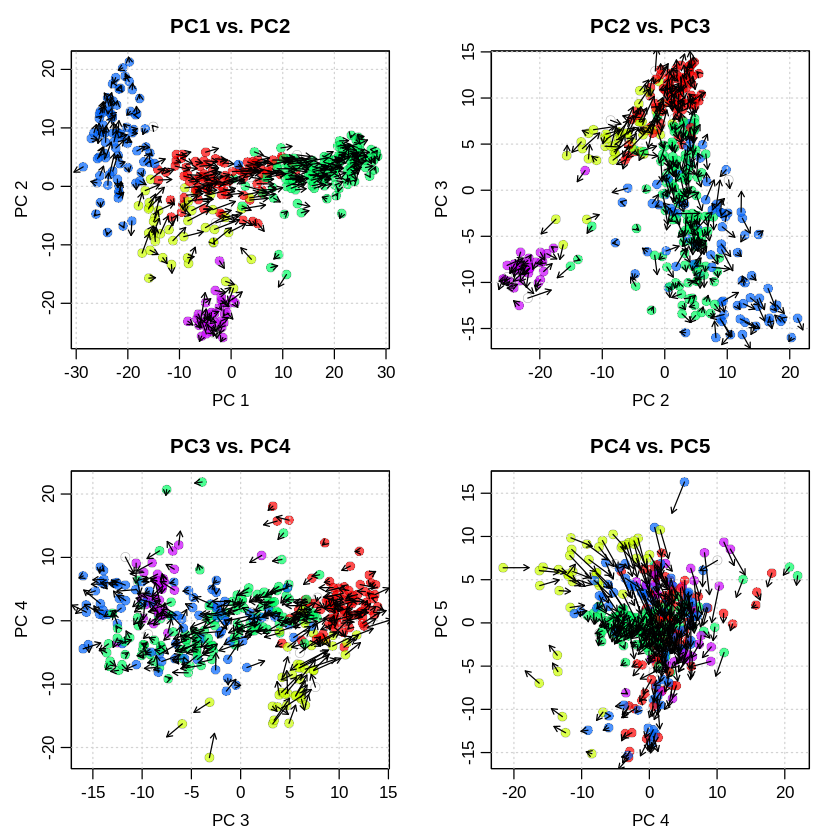

In [28]:
pca.velocity.plot(rvel1,nPcs=5,plot.cols=2,cell.colors=ac(cell.colors,alpha=0.7),cex=1.2,pcount=0.1,pc.multipliers=c(1,-1,1,1,1))

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done


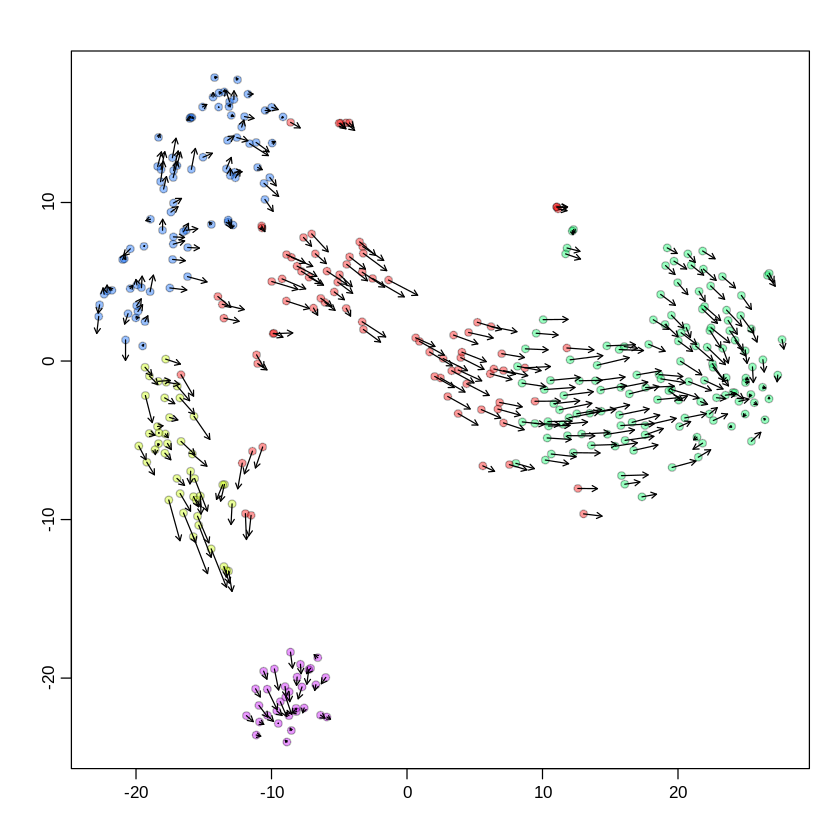

In [29]:
#Visualization on an existing embedding
#Here we use t-SNE embedding from the original publication (in emb variable).
vel <- rvel; arrow.scale=3; cell.alpha=0.4; cell.cex=1; fig.height=4; fig.width=4.5;
show.velocity.on.embedding.cor(emb,vel,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),cex=cell.cex,arrow.scale=arrow.scale,arrow.lwd=1)

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done
grid estimates ... grid.sd= 1.731696  min.arrow.size= 0.03463392  max.grid.arrow.length= 0.1013337  done


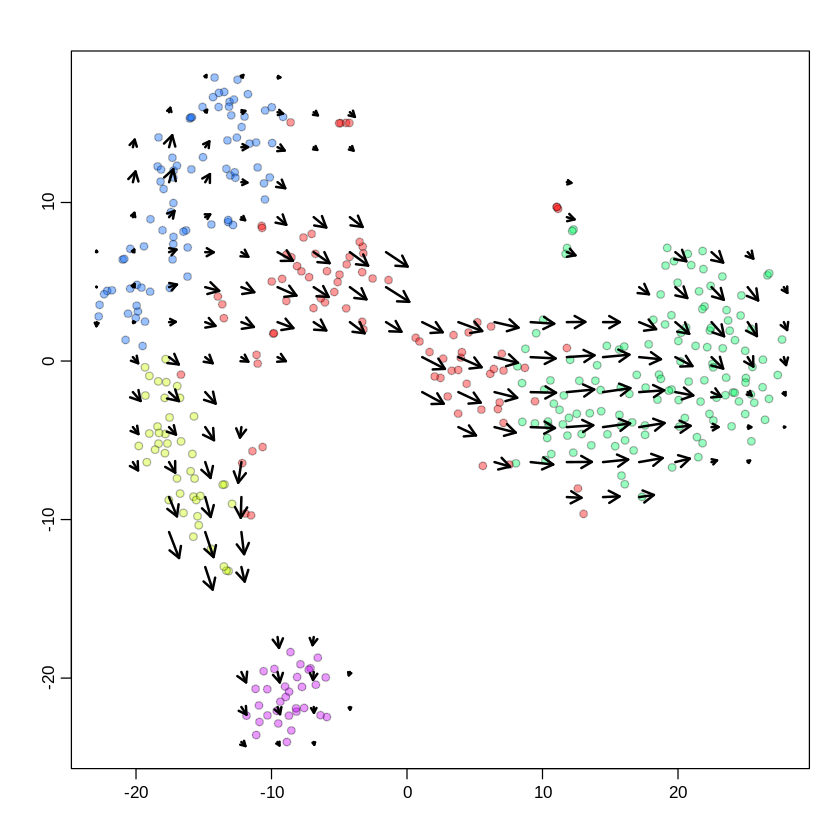

In [30]:
#Alternatively, the same function can be used to calculate a velocity vector field:
show.velocity.on.embedding.cor(emb,vel,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),cex=cell.cex,arrow.scale=arrow.scale,show.grid.flow=TRUE,min.grid.cell.mass=0.5,grid.n=20,arrow.lwd=2)

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done


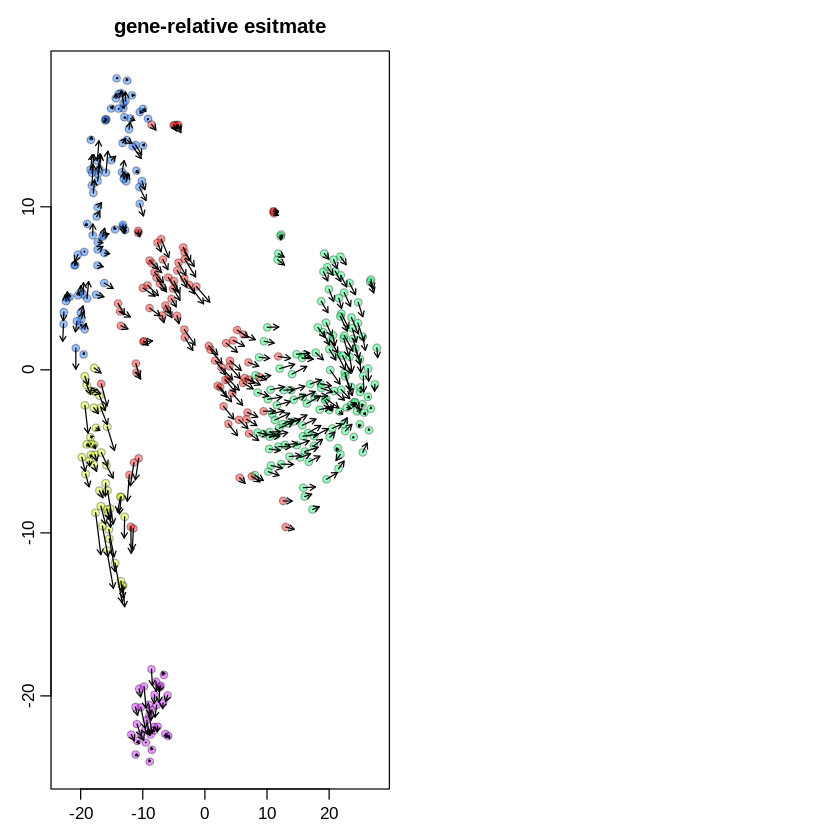

In [36]:
#We can visualize the two estimates on a pre-calculated (published) tSNE embedding:
par(mfrow=c(1,2), mar = c(2.5,2.5,2.5,1.5), mgp = c(2,0.65,0), cex = 0.85);
arrow.scale=3; cell.alpha=0.4; cell.cex=1; fig.height=4; fig.width=4.5;
#pdf(file='tsne.rvel_gvel.plots.pdf',height=6,width=12)
show.velocity.on.embedding.cor(emb,rvel,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),cex=cell.cex,arrow.scale=arrow.scale,arrow.lwd=1,main='gene-relative esitmate',do.par=F)